### Export annotations from Labelbox to GCP storage

In [1]:
import os, sys
sys.path.insert(0, os.path.abspath('..'))

%load_ext autoreload
%autoreload 2

In [2]:
from google.cloud import storage
from labelbox import Client as LabelboxClient

from utils import gcp_utils
from utils.data_management import get_annotation_path
from utils.labelbox_utils import get_annotation_objects_from_data_row_export, get_geojson_fc_from_annotation_objects, get_confidence_geojson_fc_from_annotation_objects
import geopandas as gpd

/home/ando/.conda/envs/raster_vision/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/home/ando/.conda/envs/raster_vision/lib/python3.9/site-packages/rastervision/core/data/raster_source/rasterized_source.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are enc

In [3]:
# Load environment variables from .env.
# Alternatively, manually set environment variables.

from dotenv import load_dotenv
load_dotenv()

True

In [19]:
from project_config import LABELBOX_PROJECT_ID, GCP_PROJECT_NAME
LABELBOX_API_KEY = os.getenv('LABELBOX_API_KEY')

gcp_client = storage.Client(project=GCP_PROJECT_NAME)
labelbox_client = LabelboxClient(api_key=LABELBOX_API_KEY)

#temp override LB project ID:
# LABELBOX_PROJECT_ID = 'cloqcy8v201c507yb5ar341g2' 

project = labelbox_client.get_project(LABELBOX_PROJECT_ID)

In [5]:
# CAREFUL
# Use with caution

# The following deletes all files in our GCP bucket with a _annotations.geojson file ending

"""
from project_config import BUCKET_NAME

bucket = gcp_client.get_bucket(BUCKET_NAME)
for blob in bucket.list_blobs():
    if blob.name.endswith("_annotations.geojson"):
        print(f"Deleting {blob} .. ")
        blob.delete()
"""

'\nfrom project_config import BUCKET_NAME\n\nbucket = gcp_client.get_bucket(BUCKET_NAME)\nfor blob in bucket.list_blobs():\n    if blob.name.endswith("_annotations.geojson"):\n        print(f"Deleting {blob} .. ")\n        blob.delete()\n'

In [20]:
export_params = {"project_details": True}
export = project.export_v2(params=export_params)

export.wait_till_done()
if export.errors:
  print("Errors:")
  print(export.errors)
else:
  export_full_project = export.result
  print(f"Finished without errors. Total export contains {len(export_full_project)} data rows.")
  print(len(export_full_project))

Finished without errors. Total export contains 186 data rows.
186


In [21]:
LABELBOX_PROJECT_ID

'cllbeyixh0bxt07uxfvg977h3'

# Process the annotations from Labelbox and export them to GCP storage



In [41]:
from project_config import is_validation, is_training
from utils.data_management import generate_observation_pointer
from dataclasses import dataclass, asdict
import json, random
# from utils.river_utils import 

annotation_json_list = []
geojson_feature_collection_list = []

for data_row_export in export_full_project:
    global_key_data_row = data_row_export['data_row']['global_key']

    workflow_status = data_row_export['projects'][LABELBOX_PROJECT_ID]['project_details']['workflow_status']
    # We filter depending on workflow_status
    if workflow_status in ["IN_REWORK", "TO_LABEL", "IN_REVIEW"]:
        continue
    assert workflow_status == "DONE"
    
    print(f"Processing annotations for {global_key_data_row}")
    annotated_objects = get_annotation_objects_from_data_row_export(data_row_export)
    geojson_feature_collection = get_geojson_fc_from_annotation_objects(annotated_objects)
    
    #Use this for confidence annotations
    # geojson_feature_collection = get_confidence_geojson_fc_from_annotation_objects(annotated_objects)
    # annotation_destination_path = get_annotation_path(global_key_data_row, postfix="_3class")

    annotation_destination_path = get_annotation_path(global_key_data_row)
    observation_pointer = generate_observation_pointer(annotation_destination_path, global_key_data_row, cluster_id=-99)

    
    # #convert to dict
    obs_dict = asdict(observation_pointer)
    annotation_json_list.append(obs_dict)

    # #Upload annotations geojsons to GCP folders
    gcp_utils.upload_json(gcp_client, geojson_feature_collection, annotation_destination_path)


Processing annotations for Kathajodi_Cuttack_85-85_20-44_2022-05-01_rgb_median
Processing annotations for Kathajodi_Cuttack_85-85_20-44_2022-02-01_rgb_median
Processing annotations for Ken_Banda_80-35_25-68_2022-06-01_rgb_median
Processing annotations for Ken_Banda_80-35_25-68_2022-01-01_rgb_median
Processing annotations for Narmada_Sehore_77-32_22-56_2022-01-01_rgb_median
Processing annotations for Narmada_Sehore_77-32_22-56_2022-10-01_rgb_median
Processing annotations for Tawa_Hoshangabad_77-80_22-74_2022-04-01_rgb_median
Processing annotations for Tawa_Hoshangabad_77-80_22-74_2022-01-01_rgb_median
Processing annotations for Sone_Rohtas_84-21_24-91_2022-02-01_rgb_median
Processing annotations for Sone_Rohtas_84-21_24-91_2022-05-01_rgb_median
Processing annotations for Sone_Rohtas_83-86_24-46_2023-01-01_rgb_median
Processing annotations for Sone_Rohtas_83-86_24-46_2023-06-01_rgb_median
Processing annotations for Bhargavi_Khordha_85-88_20-26_2018-12-01_rgb_median
Processing annotations

# Generate the spatial clusters

These cluster_ids can be used for spatially based holdout splits.

Number of clusters: 9 / Number of unassigned points : 0


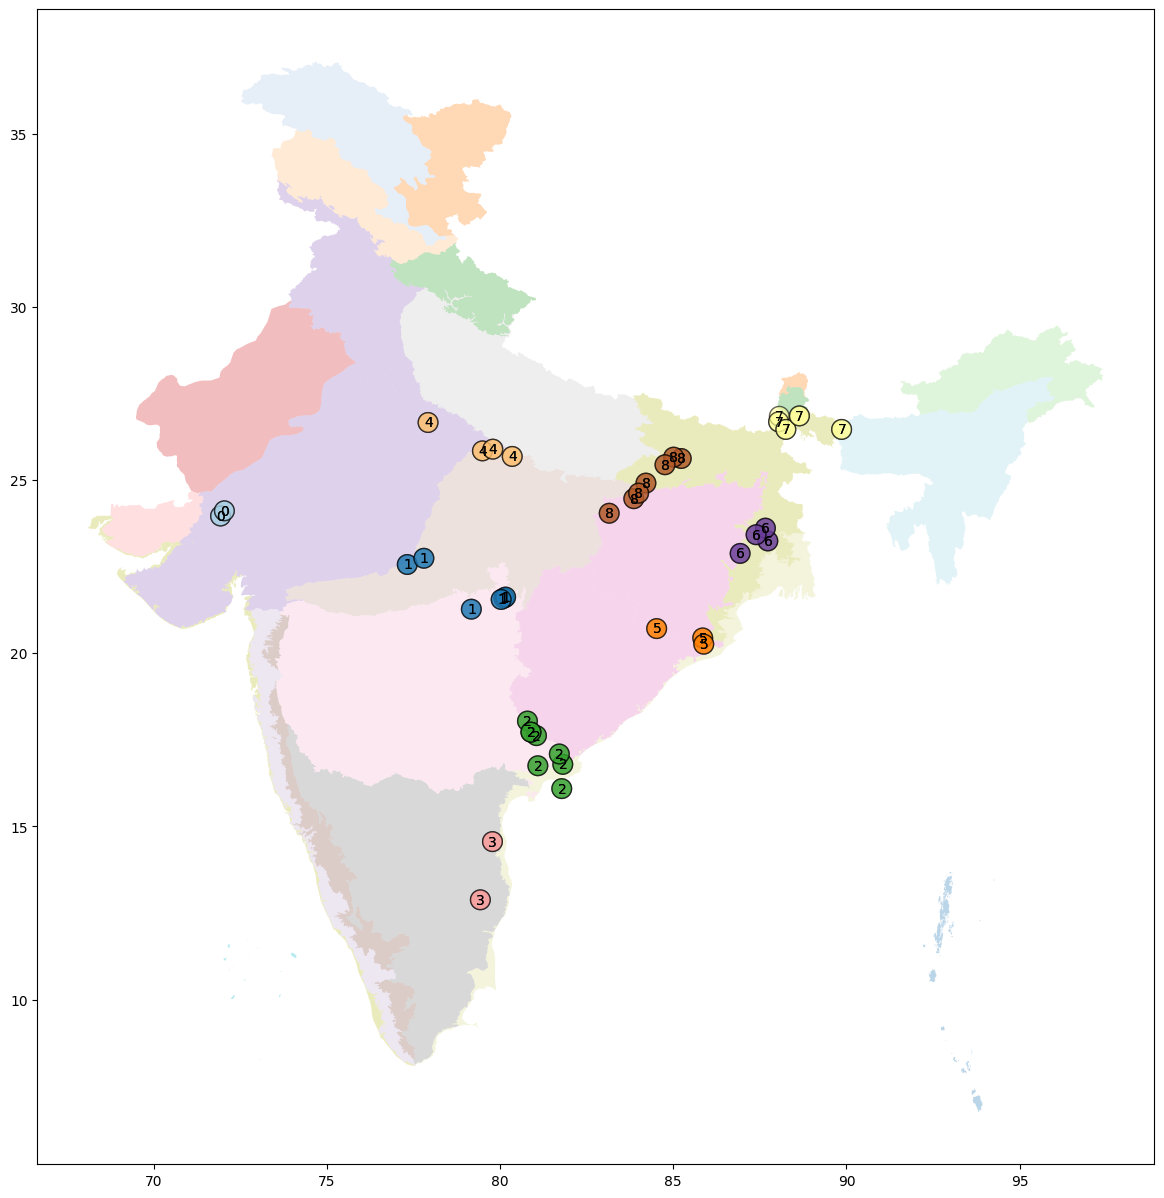

In [47]:
from utils.river_utils import cluster_observations, visualize_clusters

india_bio = gpd.read_file("/data/sand_mining/shapefiles/lyr_76_india_biogeographic.shp")
india_bio = india_bio.set_crs(4326, allow_override=True)
india_bio = [india_bio[['biogeoprov', 'geometry']]] # also turn it into a list

gdf = gpd.GeoDataFrame(annotation_json_list, geometry=gpd.points_from_xy([entry['longitude'] for entry in annotation_json_list], [entry['latitude'] for entry in annotation_json_list]))
gdf = cluster_observations(gdf, min_cluster_size=2, maximum_cluster_radius_km=250)
visualize_clusters(gdf, background_gdfs=india_bio) 


Update the dataset json with the cluster_id

In [48]:
for i, entry in enumerate(annotation_json_list):
    annotation_json_list[i]['cluster_id'] = int(gdf.iloc[i]['cluster_id'])


## Save the dataset locally

In [49]:
#get today's date
from datetime import date
today = date.today().strftime("%Y-%m-%d")

filename = "dataset_{version}_{date}.json".format(version="v0.2", date=today)
# get the current working directory
root_dir = os.getcwd()

# define the path to the new directory
dataset_dir = os.path.join(root_dir, '../dataset')

# create the directory if it doesn't exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

filename = os.path.join(dataset_dir, filename)

# Save the dataset geojson
with open(filename, 'w') as f:
    json.dump(annotation_json_list, f)
